In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split
from sklearn import metrics
from IPython.display import display, clear_output

In [ ]:
!nvidia-smi -L # list GPUs available

In [6]:
!export CUDA_VISIBLE_DEVICES=0

In [4]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]

x = {}
x_array_read = np.load("x_array.npy",allow_pickle=True)
mycounter = -1
for m1 in mass_range:
    for m2 in mass_range:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [5]:
x_vals_all = np.load("x_vals_all.npy")
y_vals_all = np.load("y_vals_all.npy")

In [534]:
x_vals_all

array([[-1.08511704, -0.13951411,  0.29623825, -1.38625319,  0.5       ,
         0.5       ],
       [-0.99621376, -0.3906208 ,  1.87209617, -1.20087092,  0.5       ,
         0.5       ],
       [-1.10503705,  1.30397829,  1.37879233, -0.51460752,  0.5       ,
         0.5       ],
       ...,
       [ 2.25225265, -1.04538567, -1.74062478, -0.42062581,  6.        ,
         6.        ],
       [ 1.9191695 , -0.87384445, -1.59395235, -2.25172332,  6.        ,
         6.        ],
       [ 0.04826932,  1.34560735, -0.34342313, -1.79483175,  6.        ,
         6.        ]])

In [8]:
#model_all_BCE = tf.keras.models.load_model("model_all_BCE_3_4096")
model_all_MSE = tf.keras.models.load_model("model_all_MSE_3_4096")

2023-10-31 13:15:51.152330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 13:15:52.281408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [9]:
def createSimpleModel(weight):
    input_layer = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation="relu",
                         kernel_initializer=tf.keras.initializers.Constant(weight))(input_layer)
    model = Model(inputs=input_layer, outputs=simple_model)
    return model

4 Features 2 Parameter Semi Weakly Supervised Model

In [337]:
#only animtes for .05 sigfrac
def train_wsmodel(sigfrac, m1, m2, w1, w2, epochs):

    sig_list = []
    w1_list = []
    w2_list = []
    w3_list = []

    max_SIC1 = []
    max_SIC2 = []

    fit_out = {}

    epsilon = 1e-6
    
    initial_learning_rate = 0.07

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=30*3, decay_rate=0.8, staircase=True
    )

    sig_space = np.logspace(-3, -1, 20)
    #for sigfrac in sig_space:
    sigfrac = sigfrac
    print("Signal Fraction: ", sigfrac)
    for l in model_all_MSE.layers:
        l.trainable=False

    model3 = createSimpleModel(w1)
    model32 = createSimpleModel(w2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all_MSE(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    LLR_xs = 1 + sigfrac * LLR - sigfrac
    #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR - model33(tf.ones_like(inputs)[:,0])
    ws = (LLR_xs / (1.+ LLR_xs))
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule))

    m1 = m1
    m2 = m2

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    #[reference (1), data_background (0), signal(0)]
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
    print(train_reference,len(x[0,0])-train_reference,len(x[m1,m2][0:int(sigfrac*train_reference)]),len(x[m1,m2][0:int(sigfrac*train_reference)])/train_reference)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    with tf.device('/GPU:0'):
        for epoch in range(epochs):
            myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=1,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
            w1_out = model_all2.trainable_weights[0].numpy()[0][0]
            w2_out = model_all2.trainable_weights[1].numpy()[0][0]
            fit_out[epoch] = [w1_out, w2_out]

    sig_list+=[sigfrac]
    w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
    w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

    print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

    scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(train_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    return fit_out
    
    #CWOLA
#     model_cwola = Sequential()
#     model_cwola.add(Dense(128, input_dim=4, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(1, activation='sigmoid'))
#     model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
#     scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
#     y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
#     fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
#     plt.plot(tpr,tpr/np.sqrt(fpr + epsilon))
#     plt.plot(tpr2,tpr2/np.sqrt(fpr2 + epsilon))
    
#     max_SIC1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
#     max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]

In [145]:
len(X_train_[:,0:4])

30988

In [146]:
len(x_vals_)

61976

In [563]:
z = {}
losses_list = []

epsilon = 1e-6

sig_space = np.logspace(-3, -1, 20)
for sig in sig_space:
    print("Signal Fraction: ", sigfrac)
    for w1 in m1_list:
        for w2 in m2_list:
            sigfrac = sig
    
            for l in model_all_MSE.layers:
                l.trainable=False

    print(w1, w2)

            model3 = createSimpleModel(w1)
            model32 = createSimpleModel(w2)

            inputs_hold3 = tf.keras.Input(shape=(1,))
            simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
            model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

            inputs = tf.keras.Input(shape=(4,))
            inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
            hidden_layer_1 = model_all_MSE(inputs2)
            LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
            LLR_xs = 1 + sigfrac*LLR - sigfrac
            #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
            ws = LLR_xs / (1.+ LLR_xs)
            model_all2 = Model(inputs = inputs, outputs = ws)
            model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

            m1 = 3
            m2 = 4.5

            test_background = int(1/2 *len(x[0,0]))
            train_background = int(1/4 * len(x[0,0]))
            train_data = int(1/4 * len(x[0,0]))
            train_reference = int(1/4 * len(x[0,0]))
            #signal
            test_signal_length = int(1/2*len(x[m1,m2]))
            N = int(1/4 * (len(x[0,0])))
            signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

            x_vals_ = np.concatenate([x[0,0][test_background:],signal])
            #[reference (0), data_background (1), signal(1)]
            y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
            #print(train_reference,len(x[0,0])-train_reference,len(x[m1,m2][0:int(sigfrac*train_reference)]),len(x[m1,m2][0:int(sigfrac*train_reference)])/train_reference)

            X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

            #myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, callbacks = [es])
            
            loss = model_all2.evaluate(x_vals_, y_vals_, verbose = 0)
            losses_list.append(loss)
    z[sigfrac, m1, m2] = losses_list
    print(np.shape(losses_list))
    losses_list = []

Signal Fraction:  0.001
0.5 0.5
0.5 1.0
0.5 1.5
0.5 2.0
0.5 2.5
0.5 3.0
0.5 3.5
0.5 4.0
0.5 4.5
0.5 5.0
0.5 5.5
0.5 6.0
1.0 0.5
1.0 1.0
1.0 1.5
1.0 2.0
1.0 2.5
1.0 3.0
1.0 3.5
1.0 4.0
1.0 4.5
1.0 5.0
1.0 5.5
1.0 6.0
1.5 0.5
1.5 1.0
1.5 1.5
1.5 2.0
1.5 2.5
1.5 3.0
1.5 3.5
1.5 4.0
1.5 4.5
1.5 5.0
1.5 5.5
1.5 6.0
2.0 0.5
2.0 1.0
2.0 1.5
2.0 2.0
2.0 2.5
2.0 3.0
2.0 3.5
2.0 4.0
2.0 4.5
2.0 5.0
2.0 5.5
2.0 6.0
2.5 0.5
2.5 1.0
2.5 1.5
2.5 2.0
2.5 2.5
2.5 3.0
2.5 3.5
2.5 4.0
2.5 4.5
2.5 5.0
2.5 5.5
2.5 6.0
3.0 0.5
3.0 1.0
3.0 1.5
3.0 2.0
3.0 2.5
3.0 3.0
3.0 3.5
3.0 4.0
3.0 4.5
3.0 5.0
3.0 5.5
3.0 6.0
3.5 0.5
3.5 1.0
3.5 1.5
3.5 2.0
3.5 2.5
3.5 3.0
3.5 3.5
3.5 4.0
3.5 4.5
3.5 5.0
3.5 5.5
3.5 6.0
4.0 0.5
4.0 1.0
4.0 1.5
4.0 2.0
4.0 2.5
4.0 3.0
4.0 3.5
4.0 4.0
4.0 4.5
4.0 5.0
4.0 5.5
4.0 6.0
4.5 0.5
4.5 1.0
4.5 1.5
4.5 2.0
4.5 2.5
4.5 3.0
4.5 3.5
4.5 4.0
4.5 4.5
4.5 5.0
4.5 5.5
4.5 6.0
5.0 0.5
5.0 1.0
5.0 1.5
5.0 2.0
5.0 2.5
5.0 3.0
5.0 3.5
5.0 4.0
5.0 4.5
5.0 5.0
5.0 5.5
5.0 6.0
5.5 0.5
5.5 1.0


In [564]:
np.save("z_sig34.5", z)

In [533]:
# sig_space = np.logspace(-3, -1, 20)

# z_sig = {}
# loss_list = []

# count = 0
# for sig in sig_space:
#     if count > 1:
#         break
#     count+=1
#     for w1 in m1_list:
#         for w2 in m2_list:
#             loss_list.append(z_sig[sigfrac, w1, w2])
            
#     z_sig[sig, 3, 4.5] = loss_list
#     loss_list = []

In [567]:
sig_list

[0.001,
 0.0012742749857031334,
 0.001623776739188721,
 0.00206913808111479,
 0.0026366508987303583,
 0.003359818286283781,
 0.004281332398719396,
 0.00545559478116852,
 0.0069519279617756054,
 0.008858667904100823,
 0.011288378916846888,
 0.01438449888287663,
 0.018329807108324356,
 0.023357214690901212,
 0.029763514416313176,
 0.0379269019073225,
 0.04832930238571752,
 0.06158482110660261,
 0.07847599703514611,
 0.1]

In [ ]:
loss_values = list(z[].values())

plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=loss_values)


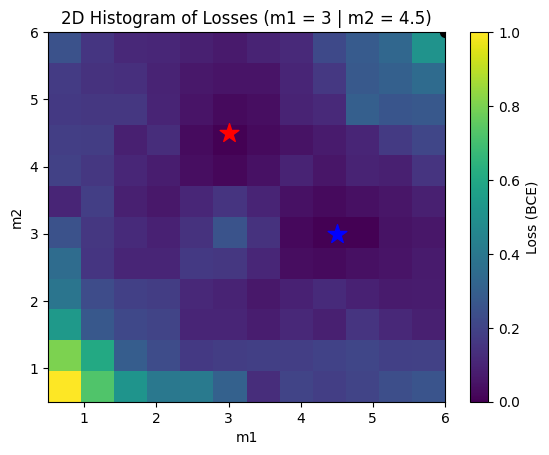

In [500]:
def loss_landscape_2D(m1, m2, w1_out, w2_out):
    m1_values, m2_values = zip(*z.keys())

    loss_values = list(z.values())
    min_loss = min(loss_values)
    max_loss = max(loss_values)

    star1_coords = (m1, m2)  
    star2_coords = (m2, m1)
    fitoutput_coords = (w1_out, w2_out)

    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    
    h = plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    plt.scatter(*fitoutput_coords, c='black', marker='.', s=200, label='fit_output')
    plt.colorbar(label='Loss (BCE)')

    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('2D Histogram of Losses (m1 = {}'.format(m1) + " | m2 = {})".format(m2))
    return h

loss_landscape_2D(3, 4.5, 6, 6);

In [10]:
m1_list = np.unique(x_vals_all[:, -2])
m2_list = np.unique(x_vals_all[:, -1])

In [11]:
m1_list

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ])

In [349]:
count = 0
test = {}
test_list = []
for m1 in m1_list:
    for m2 in m2_list:
        for w1 in m1_list:
            for w2 in m2_list:
                print(w1, w2, m1, m2)
                count+=1
                test_list.append(count)
                
                if count == (len(m1_list) * len(m2_list)):
                    test[m1,m2] = test_list
                    count = 0
                    test_list = []

0.5 0.5 0.5 0.5
0.5 1.0 0.5 0.5
0.5 1.5 0.5 0.5
0.5 2.0 0.5 0.5
0.5 2.5 0.5 0.5
0.5 3.0 0.5 0.5
0.5 3.5 0.5 0.5
0.5 4.0 0.5 0.5
0.5 4.5 0.5 0.5
0.5 5.0 0.5 0.5
0.5 5.5 0.5 0.5
0.5 6.0 0.5 0.5
1.0 0.5 0.5 0.5
1.0 1.0 0.5 0.5
1.0 1.5 0.5 0.5
1.0 2.0 0.5 0.5
1.0 2.5 0.5 0.5
1.0 3.0 0.5 0.5
1.0 3.5 0.5 0.5
1.0 4.0 0.5 0.5
1.0 4.5 0.5 0.5
1.0 5.0 0.5 0.5
1.0 5.5 0.5 0.5
1.0 6.0 0.5 0.5
1.5 0.5 0.5 0.5
1.5 1.0 0.5 0.5
1.5 1.5 0.5 0.5
1.5 2.0 0.5 0.5
1.5 2.5 0.5 0.5
1.5 3.0 0.5 0.5
1.5 3.5 0.5 0.5
1.5 4.0 0.5 0.5
1.5 4.5 0.5 0.5
1.5 5.0 0.5 0.5
1.5 5.5 0.5 0.5
1.5 6.0 0.5 0.5
2.0 0.5 0.5 0.5
2.0 1.0 0.5 0.5
2.0 1.5 0.5 0.5
2.0 2.0 0.5 0.5
2.0 2.5 0.5 0.5
2.0 3.0 0.5 0.5
2.0 3.5 0.5 0.5
2.0 4.0 0.5 0.5
2.0 4.5 0.5 0.5
2.0 5.0 0.5 0.5
2.0 5.5 0.5 0.5
2.0 6.0 0.5 0.5
2.5 0.5 0.5 0.5
2.5 1.0 0.5 0.5
2.5 1.5 0.5 0.5
2.5 2.0 0.5 0.5
2.5 2.5 0.5 0.5
2.5 3.0 0.5 0.5
2.5 3.5 0.5 0.5
2.5 4.0 0.5 0.5
2.5 4.5 0.5 0.5
2.5 5.0 0.5 0.5
2.5 5.5 0.5 0.5
2.5 6.0 0.5 0.5
3.0 0.5 0.5 0.5
3.0 1.0 0.5 0.5
3.0 1.5 

In [340]:
z_allm1m2 = np.load("z_allm1m2.npy", allow_pickle = True).item()
losses = []

epsilon = 1e-6
sigfrac = 0.05
print("Signal Fraction: ", sigfrac)
for m1 in m1_list:
    for m2 in m2_list:
        if (sigfrac,m1,m2) not in z_allm1m2:
            print(w1, w2, m1, m2)
        for w1 in m1_list:
            for w2 in m2_list:
                
                for l in model_all_MSE.layers:
                    l.trainable=False

                model3 = createSimpleModel(w1)
                model32 = createSimpleModel(w2)

                inputs_hold3 = tf.keras.Input(shape=(1,))
                simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
                model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

                inputs = tf.keras.Input(shape=(4,))
                inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
                hidden_layer_1 = model_all_MSE(inputs2)
                LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
                LLR_xs = 1 + sigfrac*LLR - sigfrac
                #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
                ws = LLR_xs / (1.+ LLR_xs)
                model_all2 = Model(inputs = inputs, outputs = ws)
                model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

                m1 = m1
                m2 = m2
                
                if (sigfrac,m1,m2) in z_allm1m2:
                    break

                test_background = int(1/2 *len(x[0,0]))
                train_background = int(1/4 * len(x[0,0]))
                train_data = int(1/4 * len(x[0,0]))
                train_reference = int(1/4 * len(x[0,0]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2]))
                N = int(1/4 * (len(x[0,0])))
                signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

                x_vals_ = np.concatenate([x[0,0][test_background:],signal])
                #[reference (0), data_background (1), signal(1)]
                y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
                
                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

                # for epoch in range(20):
                #     myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, callbacks = [es])
                #     w1_out = model_all2.trainable_weights[0].numpy()[0][0]
                #     w2_out = model_all2.trainable_weights[1].numpy()[0][0]
                #     fit_out[epoch] = [w1_out, w2_out]
                
                with tf.device('/GPU:0'):
                    loss = model_all2.evaluate(x_vals_, y_vals_, verbose = 0)
                losses.append(loss)

        if (sigfrac,m1,m2) in z_allm1m2:
            print("Landscape for m1 = {} ".format(m1) + "and " + "m2 = {} ".format(m2) +" already exists for " + "{}".format(sigfrac) + " signal fraction")
        else:
            z_allm1m2[sigfrac,m1,m2] = losses
            losses = []
            np.save("z_allm1m2", z_allm1m2)

Signal Fraction:  0.05
Landscape for m1 = 0.5 and m2 = 0.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 1.0  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 1.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 2.0  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 2.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 3.0  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 3.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 4.0  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 4.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 5.0  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 5.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 6.0  already exists for 0.05 signal fraction
Landscape for m1 = 1.0 and m2 = 0.5  already exists f

In [403]:
z_allm1m2.keys()

dict_keys([(0.05, 0.5, 0.5), (0.05, 0.5, 1.0), (0.05, 0.5, 1.5), (0.05, 0.5, 2.0), (0.05, 0.5, 2.5), (0.05, 0.5, 3.0), (0.05, 0.5, 3.5), (0.05, 0.5, 4.0), (0.05, 0.5, 4.5), (0.05, 0.5, 5.0), (0.05, 0.5, 5.5), (0.05, 0.5, 6.0), (0.05, 1.0, 0.5), (0.05, 1.0, 1.0), (0.05, 1.0, 1.5), (0.05, 1.0, 2.0), (0.05, 1.0, 2.5), (0.05, 1.0, 3.0), (0.05, 1.0, 3.5), (0.05, 1.0, 4.0), (0.05, 1.0, 4.5), (0.05, 1.0, 5.0), (0.05, 1.0, 5.5), (0.05, 1.0, 6.0), (0.05, 1.5, 0.5), (0.05, 1.5, 1.0), (0.05, 1.5, 1.5), (0.05, 1.5, 2.0), (0.05, 1.5, 2.5), (0.05, 1.5, 3.0), (0.05, 1.5, 3.5), (0.05, 1.5, 4.0), (0.05, 1.5, 4.5), (0.05, 1.5, 5.0), (0.05, 1.5, 5.5), (0.05, 1.5, 6.0), (0.05, 2.0, 0.5), (0.05, 2.0, 1.0), (0.05, 2.0, 1.5), (0.05, 2.0, 2.0), (0.05, 2.0, 2.5), (0.05, 2.0, 3.0), (0.05, 2.0, 3.5), (0.05, 2.0, 4.0), (0.05, 2.0, 4.5), (0.05, 2.0, 5.0), (0.05, 2.0, 5.5), (0.05, 2.0, 6.0), (0.05, 2.5, 0.5), (0.05, 2.5, 1.0), (0.05, 2.5, 1.5), (0.05, 2.5, 2.0), (0.05, 2.5, 2.5), (0.05, 2.5, 3.0), (0.05, 2.5, 3.5),

In [27]:
import random
grid_axes = {}
for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        grid_axes[m1,m2] = random.randint(1, 10)

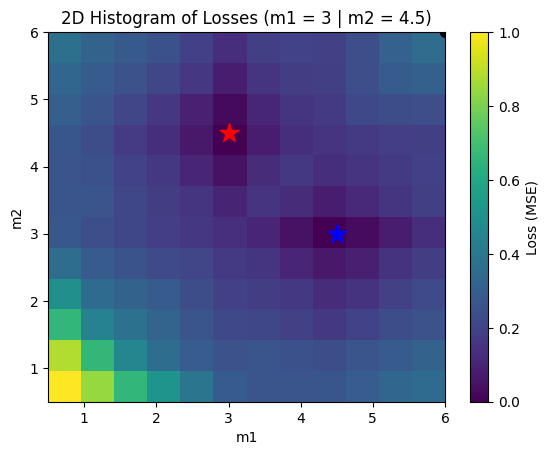

In [501]:
def loss_landscape_2D(sigfrac, m1, m2, w1_out, w2_out):
    m1_values, m2_values = zip(*grid_axes.keys())

    loss_values = list(z_allm1m2[sigfrac, m1, m2])
    min_loss = min(loss_values)
    max_loss = max(loss_values)

    star1_coords = (m1, m2)  
    star2_coords = (m2, m1)
    fitoutput_coords = (w1_out, w2_out)

    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    
    h = plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    plt.scatter(*fitoutput_coords, c='black', marker='.', s=200, label='fit_output')
    plt.colorbar(label='Loss (MSE)')

    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('2D Histogram of Losses (m1 = {}'.format(m1) + " | m2 = {})".format(m2))
    return h

loss_landscape_2D(0.05, 3, 4.5, 6, 6);

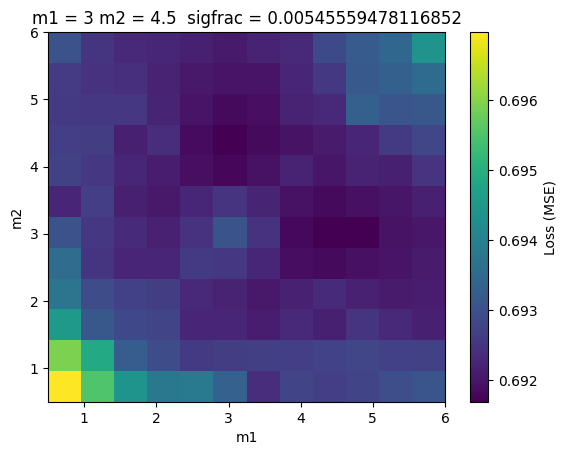

In [518]:
m1_values, m2_values = zip(*z.keys())

loss_values = list(z.values())

h = plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=loss_values)
plt.title("m1 = {} ".format(3) + "m2 = {} ".format(4.5) + " sigfrac = {}".format(0.00545559478116852))
plt.xlabel("m1")
plt.ylabel("m2")
plt.colorbar(label='Loss (MSE)')
plt.show()

Final weight coordinates: w1 = 0.9161213040351868  w2 = 5.421537399291992 


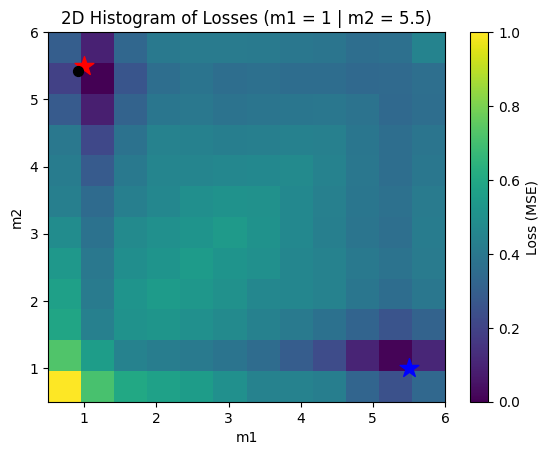

In [419]:
def animate(sigfrac, m1,m2, w1, w2, epochs):
    for key, value in train_wsmodel(sigfrac, m1, m2, w1, w2, epochs).items():
        w1_fit_coord = value[0]
        w2_fit_coord = value[1]

        plt.figure()
        loss_landscape_2D(sigfrac, m1, m2, w1_fit_coord, w2_fit_coord)
        plt.show()
        clear_output(wait=True)
        
    loss_landscape_2D(sigfrac, m1, m2, w1_fit_coord, w2_fit_coord)
    print("Final weight coordinates: w1 = {} ".format(w1_fit_coord) + " w2 = {} ".format(w2_fit_coord))
        
sigfrac = 0.05
w1, w2 = 2, 3
m1, m2 = 1, 5.5
epochs = 50
animate(sigfrac, m1, m2, w1, w2, epochs)

Final weight coordinates: w1 = 0.997785210609436  w2 = 5.534912109375 


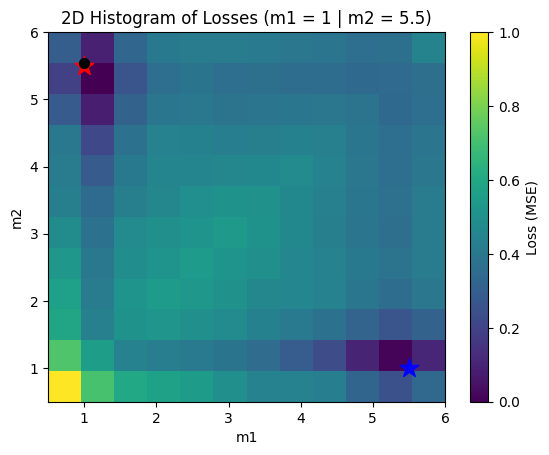

In [540]:
def animate_random(sigfrac, m1,m2, w1, w2, epochs):
    print(f"Initial Weights: {w1} {w2}")
    animate(sigfrac, m1, m2, w1, w2, epochs)
    
sigfrac = 0.05
random_number1 = random.uniform(0.1, 6.0)
random_number2 = random.uniform(0.1, 6.0)
m1, m2 = 1, 5.5
epochs = 50

animate_random(sigfrac, m1,m2, random_number1, random_number2, 50)

In [418]:
#save images to make them gifs
import os
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence

def create_gif(sigfrac, m1, m2, w1, w2):
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)

    for key, value in train_wsmodel(sigfrac, m1, m2, w1, w2, epochs).items():
        w1_fit_coord = value[0]
        w2_fit_coord = value[1]

        loss_landscape_2D(sigfrac, m1, m2, w1_fit_coord, w2_fit_coord)

        image_path = os.path.join(output_directory, f'hist_{key}.png')
        plt.savefig(image_path)
        plt.close()

        clear_output(wait=True)

    #make the gif
    frames = []

    image_dir = '2dhist_images'
    image_files = os.listdir(image_dir)

    image_files = sorted([filename for filename in os.listdir(image_dir) if filename.endswith('.png')], key=lambda x: int(x.split('_')[1].split('.')[0]))
    for filename in image_files:
        image = Image.open(os.path.join(image_dir, filename))
        frames.append(image)
        os.remove(image_dir+"/"+filename)

    output_gif_filename = f'{sigfrac, m1, m2, w1, w2}.gif'
    frames[0].save(output_gif_filename, save_all=True, append_images=frames[1:], duration=200, loop=0)
    
sigfrac = 0.05
w1, w2 = 2, 3
m1, m2 = 1, 5.5
epochs = 50
create_gif(sigfrac, m1, m2, w1, w2)

Signal Fraction:  0.05
30232 90698 1511 0.049980153479756546
31/31 [==============================] - 0s 10ms/step - loss: 0.2457 - val_loss: 0.2458
1 5.5 0.99775696 5.54697
64/64 [==============================] - 0s 2ms/step


In [549]:
sig_list = []
w1_list = []
w2_list = []
w3_list = []

max_SIC1 = []
max_SIC2 = []

test_list = []

epsilon = 1e-6

sigfrac = 0.05
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
initial_learning_rate = 0.02

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=30*3, decay_rate=0.9, staircase=True
)

class LearningRateSchedulerCallback(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', patience=3, decay_factor=0.9):
        super(LearningRateSchedulerCallback, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.best_loss = float('inf')
        self.wait = 0
        self.decay_factor = decay_factor
        self.initial_learning_rate = None

    def on_epoch_begin(self, epoch, logs=None):
        if self.initial_learning_rate is None:
            # Get the initial learning rate from the optimizer's configuration
            optimizer_config = self.model.optimizer.get_config()
            self.initial_learning_rate = optimizer_config['learning_rate']

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get(self.monitor)

        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.wait = 0
                if self.best_loss < current_loss:
                    self.best_loss = current_loss
                else:
                    # Reduce the learning rate if the loss hasn't improved
                    new_learning_rate = self.initial_learning_rate * self.decay_factor
                    # Update the learning rate in the optimizer
                    tf.keras.backend.set_value(self.model.optimizer.lr, new_learning_rate)
                    print("Reduced learning rate to:", new_learning_rate)


lr_scheduler_callback = LearningRateSchedulerCallback(patience=3, decay_factor=0.9)

num_data_points = len(X_train_) 
mse_loss = tf.keras.losses.MeanSquaredError()

def normalized_mse(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    num_data_points = tf.reduce_sum(1.0)
    normalized_mse = mse / num_data_points
    return normalized_mse


sig_space = np.logspace(-3, -1, 20)
count = 0
for sigfrac in sig_space:
    print("Signal Fraction: ", sigfrac)
    for l in model_all_MSE.layers:
        l.trainable=False
    
    model3 = createSimpleModel(2)
    model32 = createSimpleModel(4.5)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all_MSE(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    LLR_xs = 1 + sigfrac * LLR - sigfrac
    #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR - model33(tf.ones_like(inputs)[:,0])
    ws = (LLR_xs / (1.+ LLR_xs))
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss=normalized_mse, optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule))

    m1 = 1
    m2 = 5.5

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    #[reference (1), data_background (0), signal(0)]
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=100,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, callbacks = [es, lr_scheduler_callback])

    sig_list+=[sigfrac]
    w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
    w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

    print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    
    count+=1

    #CWOLA
#     model_cwola = Sequential()
#     model_cwola.add(Dense(128, input_dim=4, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(1, activation='sigmoid'))
#     model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
#     scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
#     y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
#     fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
#     plt.plot(tpr,tpr/np.sqrt(fpr + epsilon))
#     plt.plot(tpr2,tpr2/np.sqrt(fpr2 + epsilon))
    
#     max_SIC1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
#     max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]

Signal Fraction:  0.001
Epoch 1/100
30/30 [==============================] - 1s 17ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 2/100
30/30 [==============================] - 0s 10ms/step - loss: 0.2499 - val_loss: 0.2499
Epoch 3/100
30/30 [==============================] - 0s 9ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 4/100
30/30 [==============================] - 0s 8ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 5/100
30/30 [==============================] - 0s 8ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 6/100
30/30 [==============================] - 0s 8ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 7/100
30/30 [==============================] - 0s 7ms/step - loss: 0.2499 - val_loss: 0.2500
1 5.5 2.021771 4.293093
Signal Fraction:  0.0012742749857031334
Epoch 1/100
30/30 [==============================] - 1s 13ms/step - loss: 0.2499 - val_loss: 0.2499
Epoch 2/100
30/30 [==============================] - 0s 7ms/step - loss: 0.2499 - val_loss: 0.2500
Epoch 3/100
30/30 

In [445]:
sig_list

[0.001,
 0.0012742749857031334,
 0.001623776739188721,
 0.00206913808111479,
 0.0026366508987303583,
 0.003359818286283781,
 0.004281332398719396,
 0.00545559478116852,
 0.0069519279617756054,
 0.008858667904100823,
 0.011288378916846888,
 0.01438449888287663,
 0.018329807108324356,
 0.023357214690901212,
 0.029763514416313176,
 0.0379269019073225,
 0.04832930238571752,
 0.06158482110660261,
 0.07847599703514611,
 0.1]

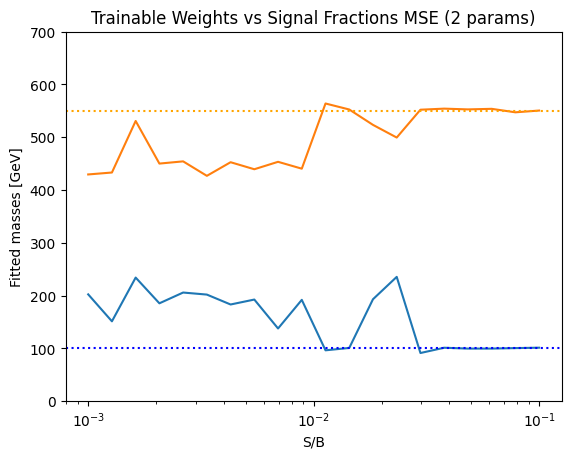

In [550]:
plt.plot(sig_list,np.array(w1_list)*100)
plt.plot(sig_list,np.array(w2_list)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (2 params)")
plt.axhline(m2 * 100,ls=":",color='orange')
plt.axhline(m1 * 100,ls=":",color='blue')
#plt.legend()
plt.ylim([0,700])
plt.show()

Text(0.5, 1.0, 'S/B vs Fitted S/B')

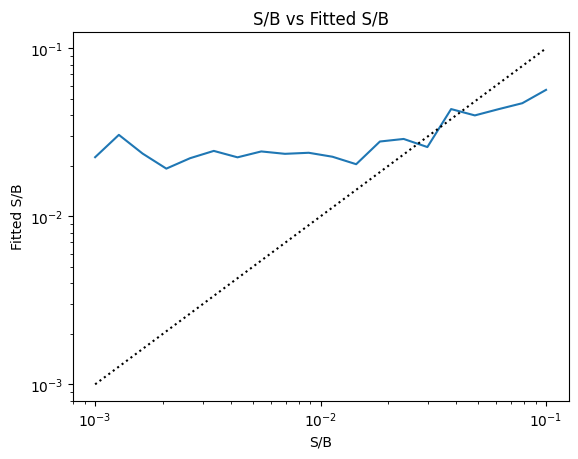

In [544]:
plt.plot(sig_list,np.array(w3_list))
plt.xscale("log")
plt.yscale("log")
plt.plot(sig_list,sig_list,ls=":",color="black")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")
plt.title("S/B vs Fitted S/B")

In [485]:
# plt.plot(sig_list,max_SIC1,label="Weakly, Semisupervised")
# plt.plot(sig_list,max_SIC2,label="Weakly Supervised")
# plt.title("CWOLA vs Semi Weakly (Trainable mu)")
# plt.legend()
# plt.xscale("log")
# plt.xlabel("Signal region S/B")
# plt.ylabel("max SIC")